# GUIA 3

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist, fashion_mnist
import random
from sklearn.metrics import roc_curve, auc


### Ejercicio 1

![image.png](enunciados/ej1.png)

Partiendo de la densidad conjunta $p_{XY}(x, y)$, podemos intentar factorizarla en dos funciones, de forma de que se cumpla que una de ellas solo dependa de x, y la otra dependa de x e y, tal que 


$p_{XY}(x, y) = p_X(x) \cdot p{Y|X}(y|x)$

$ \frac{ e^{ -( 2x + \frac{ y }{ 4x+2 } ) } }{ 2x+1 } \cdot 1 \{ x > 0, y > 0\} = 2 \cdot e^{-2x} \cdot 1 \{ x>0 \} \cdot \frac{1}{4x+2} e^{- \frac{1}{4x+2}y} \cdot 1 \{ y>0 \}$

Se puede ver que

$X \sim \varepsilon(2) $

Y que

$Y|_{X = x} \sim \varepsilon (\frac{1}{4x+2}) $

Entonces, si $T \sim \varepsilon( \lambda )$ entonces $k \cdot T \sim \varepsilon( \frac {\lambda}{k} )$ se puede decir que

$Y = \varepsilon(1) \cdot (4X+2) $


Habiendolo factorizado de este modo, X corresponde como la causa, e Y es el efecto.

### Ejercicio 2

![image.png](enunciados/ej2.png)

In [32]:
# Cargamos los datos

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


#del x_train, y_train, x_test, y_test


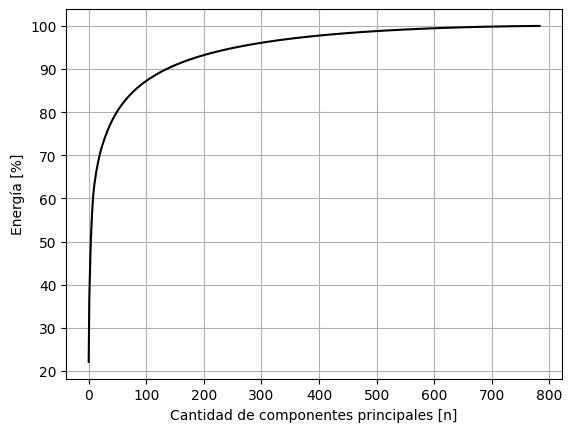

In [33]:
# a)

n_samples_train = x_train.shape[0]
n_samples_test = x_test.shape[0]
X_train = x_train.reshape(n_samples_train, -1)  # Cada imagen es ahora un vector de 784 elementos
X_test = x_test.reshape(n_samples_test, -1)
# Tengo 60000 vectores de 784 elementos (28x28 de c/imagen)

# Calculo la media y la varianza para normalizar
u_train = np.mean(X_train, axis=0)
var_train = np.std(X_train, axis=0)

# Normalizo
X_train_norm = (X_train - u_train)/var_train

# Calculo matriz de covarianza
cov_train = np.cov(X_train_norm.T)

# Calculo AVals, AVecs de la matriz de covarianza
avals, avecs = np.linalg.eig(cov_train)

# Busco los indices que me ordenan los autovalores de mayor a menor
# Igual np.linalg.eig() me parece que los devuelve ordenados de mayor a menor
index_ordenado = np.argsort(avals)[::-1]
avals = avals[index_ordenado]
avecs = avecs[:, index_ordenado]

# Calculo potencias
potencias =  np.cumsum(avals) / np.sum(avals) * 100

# Grafico

plt.figure()
plt.plot(potencias, color = 'k')
plt.xlabel('Cantidad de componentes principales [n]')
plt.ylabel('Energía [%]')
plt.grid(True)
plt.show()


#del n_samples_train, n_samples_test, X_train, X_test, u_train, var_train
#del X_train_norm, cov_train, avals, avecs, index_ordenado, potencias


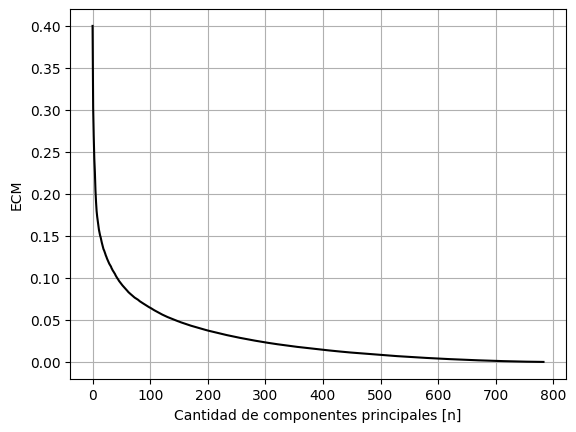

In [34]:
# b) ECM de testeo vs. Cant de componentes principales

def reconstruccion (x_est_ant, avec_n, x):
    return x_est_ant + np.dot(x, avec_n) * avec_n


X_test_norm = (X_test - u_train) / var_train

ECMs = []

for j in range(n_samples_test):
    X_est_ant = np.zeros_like(X_test_norm[j])
    ECM = []
    for i in range(784):
        X_est = reconstruccion(X_est_ant, avecs[:, i], X_test_norm[j])
        reconst = X_est * var_train + u_train
        ECM.append(np.mean((X_test[j] - reconst)**2))
        X_est_ant = X_est
    ECMs.append(ECM)    

ECM_matrix = np.array(ECMs)


ECM = np.mean(ECM_matrix, axis=0)/X_test.shape[0] # axis=0 promedia todas las filas (10000 imágenes)

plt.figure()
plt.plot(ECM, color = 'k')
plt.xlabel('Cantidad de componentes principales [n]')
plt.ylabel('ECM')
plt.grid(True)
plt.show()


#del X_test_norm, ECMs, i, j, X_est_ant, ECM, X_est, reconst, ECM_matrix




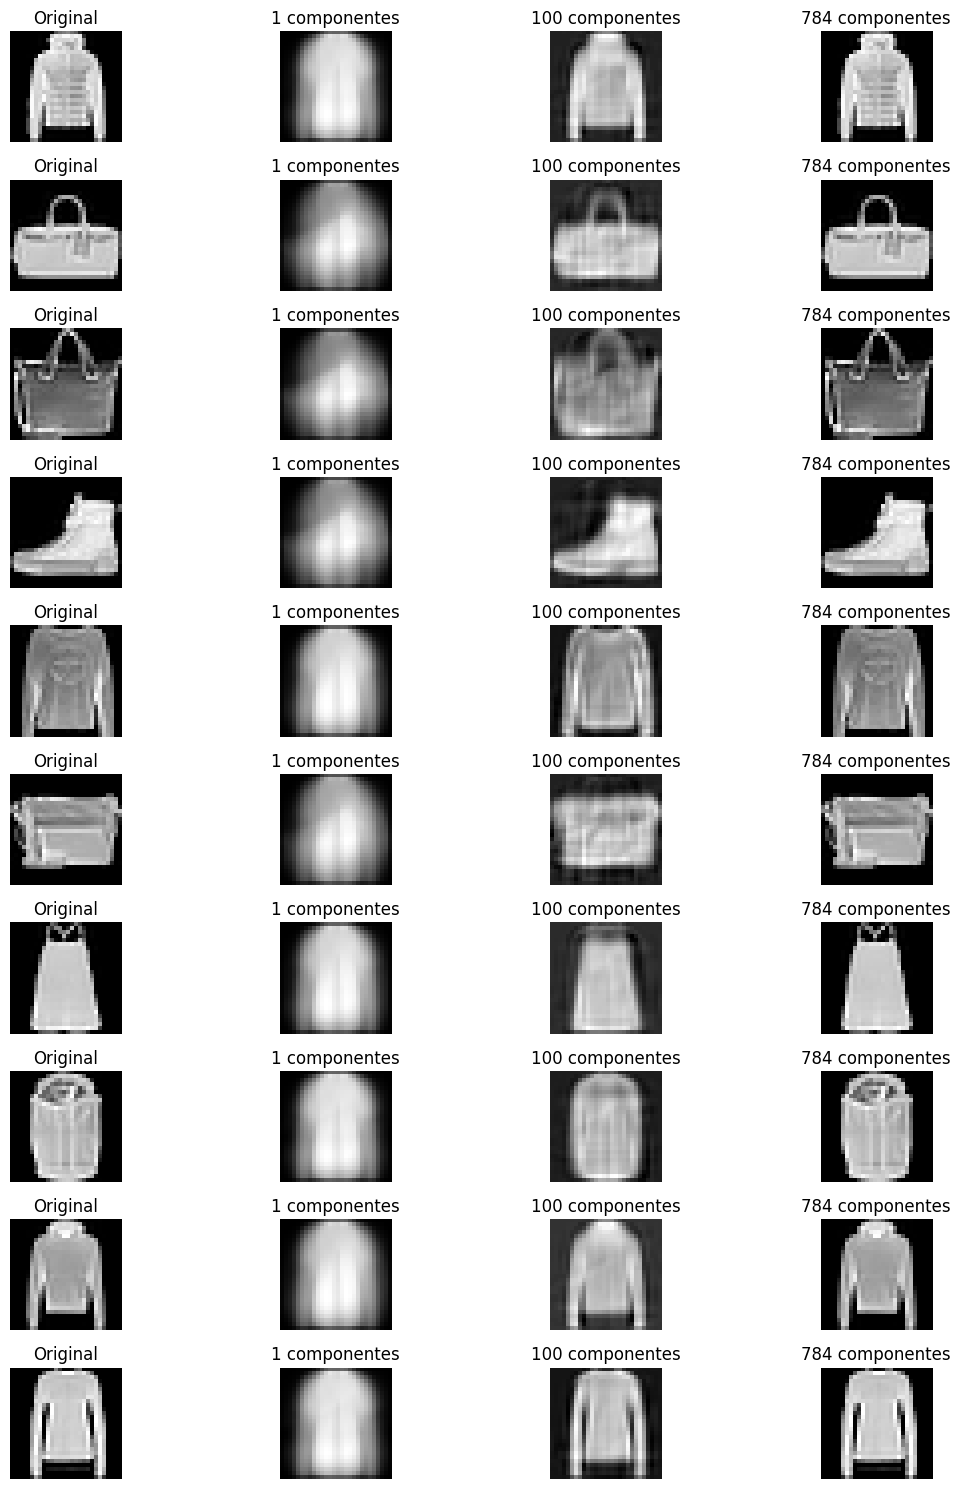

In [ ]:
# c) Elegir 10 img al azar y comparar su reconstr usando 1, 100 y 784 CP


num_images = 10
random_indices = random.sample(range(X_test.shape[0]), num_images)
imagenes_test = X_test[random_indices]
imagenes_test = imagenes_test.reshape(imagenes_test.shape[0], -1)

componentes = [1, 100, 784]

# Configurar la figura para mostrar las imágenes originales y reconstruidas
fig, axes = plt.subplots(num_images, len(componentes) + 1, figsize=(12, 15))


for i, img in enumerate(imagenes_test):
    # Muestro la imagen original
    axes[i, 0].imshow(img.reshape(28, 28), cmap='gray')
    axes[i, 0].set_title("Original")
    axes[i, 0].axis("off")
    
    # Centro la imagen
    #img_centered = (img - u_train)
    img_centered = (img - u_train) / var_train
    

    for j, k in enumerate(componentes):
        # Proyecto y reconstruyo con k componentes principales
        transformed_img_k = np.dot(img_centered, avecs[:, :k])
        #reconstructed_img_k = np.dot(transformed_img_k, avecs[:, :k].T) + u_train
        reconstructed_img_k = var_train * np.dot(transformed_img_k, avecs[:, :k].T) + u_train


        # Muestro la imagen reconstruida
        axes[i, j + 1].imshow(reconstructed_img_k.reshape(28, 28), cmap='gray')
        axes[i, j + 1].set_title(f'{k} componentes')
        axes[i, j + 1].axis("off")

plt.tight_layout()
plt.show()


#del num_images, random_indices, imagenes_test, componentes, fig, axes, i, img, img_centered, j, k, transformed_img_k, reconstructed_img_k



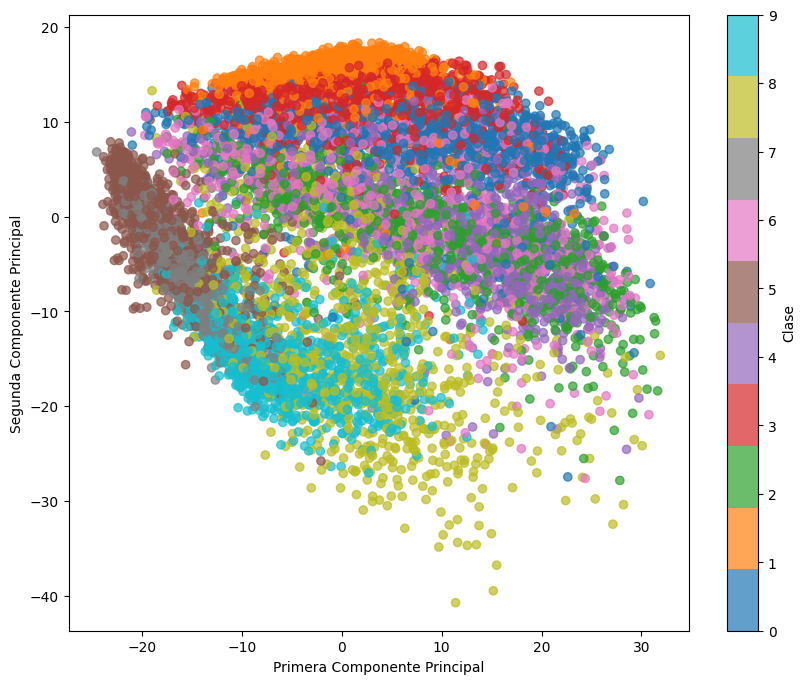

In [ ]:
# d) scatter de las dos primeras CP de las img_test, 1 color p/c/clase

# Vuelvo a traer las imagenes para incluir los labels
(_, _), (test_images, test_labels) = fashion_mnist.load_data()
data_test = test_images.reshape(test_images.shape[0], -1)  # Aplana las imágenes

#Normalizo
data_test_centered = (data_test - u_train) / var_train 

# Proyectar los datos de prueba en las dos primeras componentes principales
# Con avecs[:, :2] uso solo las primeras 2 CP
transformed_data_2d = np.dot(data_test_centered, avecs[:, :2])

# Graficar el scatter plot con colores según la clase
plt.figure(figsize=(10, 8))
scatter = plt.scatter(transformed_data_2d[:, 0], transformed_data_2d[:, 1], c=test_labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10), label='Clase')
plt.xlabel("Primera Componente Principal")
plt.ylabel("Segunda Componente Principal")
plt.show()


#del test_images, test_labels, data_test, data_test_centered, transformed_data_2d, scatter



In [ ]:
# e) Combinar base de datos fashion con digitos, para despues detectar anomalias

# Por las dudas, vuelvo a traer la DB de fashion
(_, _), (x_test, y_test) = fashion_mnist.load_data()
(_, _), (x_test_mnist, y_test_mnist) = mnist.load_data()

# Concateno las DB
x_combinado = np.concatenate((x_test, x_test_mnist), axis=0)
x_combinado = x_combinado.reshape(x_combinado.shape[0], -1)
y_combinado = np.concatenate((y_test, y_test_mnist), axis=0)
n_fashion = x_test.shape[0]
n_mnist = x_test_mnist.shape[0]


#del x_test_mnist, y_test_mnist, x_combinado, y_combinado, n_fashion, n_mnist



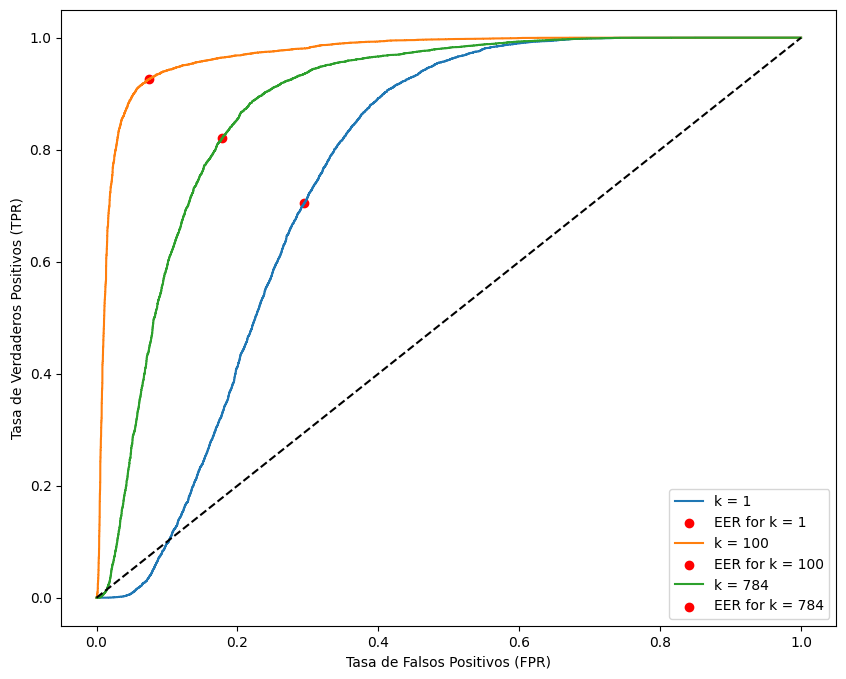

In [71]:
# f) 


def calculate_mse_for_components(x, media, avecs, k):
    # Proyección y reconstrucción
    transform = np.dot(x - media, avecs[:, :k])
    reconst = np.dot(transform, avecs[:, :k].T) + media
    # Calcular el error cuadrático medio (MSE)
    mse = np.mean((x - reconst) ** 2, axis=1)
    return mse


# Vuelvo a traer todo, y repito pasos de entrenamiento con datos de fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

n_samples_train = x_train.shape[0]
n_samples_test = x_test.shape[0]
X_train = x_train.reshape(n_samples_train, -1)  # Cada imagen es ahora un vector de 784 elementos
X_test = x_test.reshape(n_samples_test, -1)
# Tengo 60000 vectores de 784 elementos (28x28 de c/imagen)

# Calculo la media y la varianza para normalizar
u_train = np.mean(X_train, axis=0)
var_train = np.std(X_train, axis=0)

# Normalizo
X_train_norm = (X_train - u_train)/var_train

# Calculo matriz de covarianza
cov_train = np.cov(X_train_norm.T)

# Calculo AVals, AVecs de la matriz de covarianza
avals, avecs = np.linalg.eig(cov_train)

# Busco los indices que me ordenan los autovalores de mayor a menor
# Igual np.linalg.eig() me parece que los devuelve ordenados de mayor a menor
index_ordenado = np.argsort(avals)[::-1]
avals = avals[index_ordenado]
avecs = avecs[:, index_ordenado]


# Definir la cantidad de componentes a probar
components_to_test = [1, 100, 784]

# Graficar las curvas ROC para cada cantidad de componentes principales
plt.figure(figsize=(10, 8))

for k in components_to_test:
    # Calcular el MSE para k componentes
    mse = calculate_mse_for_components(x_combinado, u_train, avecs, k)
    
    # Etiqueta binaria: 0 para normales (FASHION-MNIST) y 1 para anómalas (MNIST)
    labels = np.concatenate((np.zeros(n_fashion), np.ones(n_mnist)))
    
    # Calcular la curva ROC y el área bajo la curva (AUC)
    fpr, tpr, thresholds = roc_curve(labels, mse)
    
    # Encontrar el equal error rate (EER) como el punto donde FPR ≈ 1 - TPR
    eer_threshold = thresholds[np.nanargmin(np.abs(fpr - (1 - tpr)))]
    eer_index = np.nanargmin(np.abs(fpr - (1 - tpr)))
    eer_fpr = fpr[eer_index]
    eer_tpr = tpr[eer_index]
    
    # Graficar la curva ROC
    plt.plot(fpr, tpr, label=f'k = {k}')
    plt.scatter(eer_fpr, eer_tpr, color='red', label=f'EER for k = {k}')
    

# Configuración del gráfico
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend()
plt.show()




### Interpretación

Como venimos viendo en los incisos anteriores, no siempre incrementar y usar la mayor cantidad de componentes principales asegura un mejor desempeño del algoritmo. En este caso, utilizar 100 componentes principales asegura el mejor desempeño dentro de esta comparación. Esto se debe a que es el que tiene la mayor AUC (Area Under the Curve), que en caso óptimo seria 1.

Utilizar 100 componentes principales asegura un alto TPR, manteniendo un bajo FPR, y un balance adecuado en la utilización de los recursos de computo.

Utilizar 1 componente no tiene buen desempeño por tratarse de un underfitting, mientras que lo opuesto sucede con utilizar 784 y el overfitting

Se resalta la importancia de los primeros 2 graficos (Energía y ECM), donde se puede ver que cerca del 90% de la energía de las componentes se encuentra comprendida en las primeras 100, y que el ECM al utilizar esta cantidad es bajo (y no disminuye mucho al usar, por ejemplo, 200 componentes).